In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")


In [2]:
import yfinance as yf
df = yf.download('005930.KS',
                     start='2018-01-01',
                     end='2023-03-01') # 005930 : 삼성전자 주가

[*********************100%***********************]  1 of 1 completed


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1270 entries, 2018-01-02 to 2023-02-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1270 non-null   float64
 1   High       1270 non-null   float64
 2   Low        1270 non-null   float64
 3   Close      1270 non-null   float64
 4   Adj Close  1270 non-null   float64
 5   Volume     1270 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 69.5 KB


In [4]:
df = df[["Close"]] # 종가 기준
df = df.reset_index()
df.columns = ['date', 'price']

In [5]:
# object를 datetype로 변환
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

df.head()

,price
date,
2018-01-02,51020.0
2018-01-03,51620.0
2018-01-04,51080.0
2018-01-05,52120.0
2018-01-08,52020.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1270 entries, 2018-01-02 to 2023-02-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   1270 non-null   float64
dtypes: float64(1)
memory usage: 19.8 KB


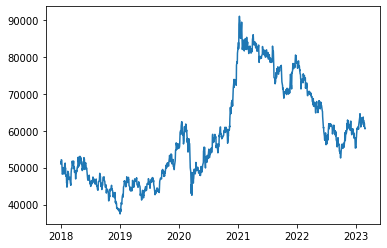

In [7]:
plt.plot(df.index, df['price'])
plt.show()
#비정상 시계열로 보인다

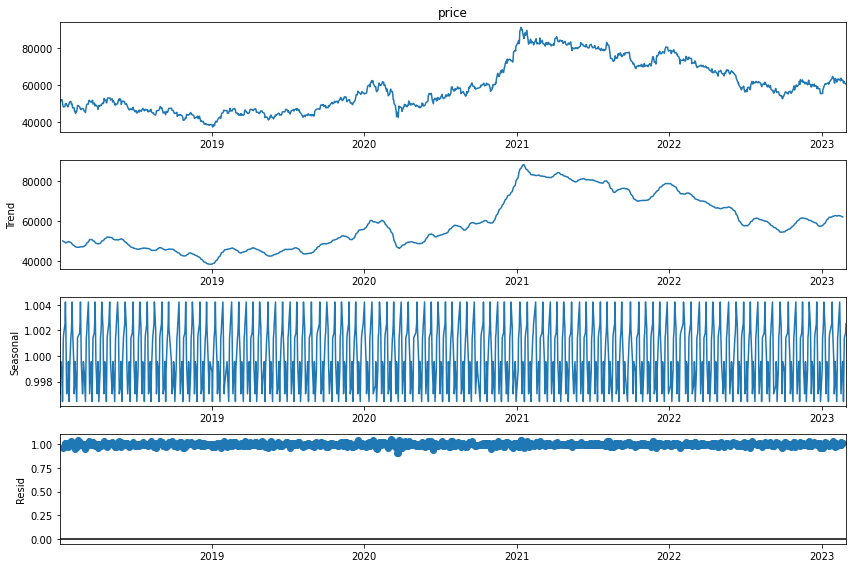

In [8]:
ts = df.price
result = seasonal_decompose(ts, model = 'multiplicative',period=12) #승법모형
plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()
# 시계열 분해 , Seasonal이 존재

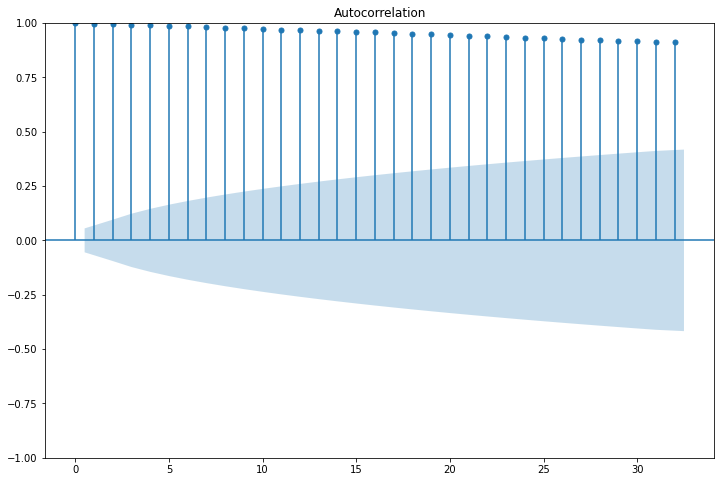

In [9]:
# ACF, PACF plot
plot_acf(df)
plt.show()

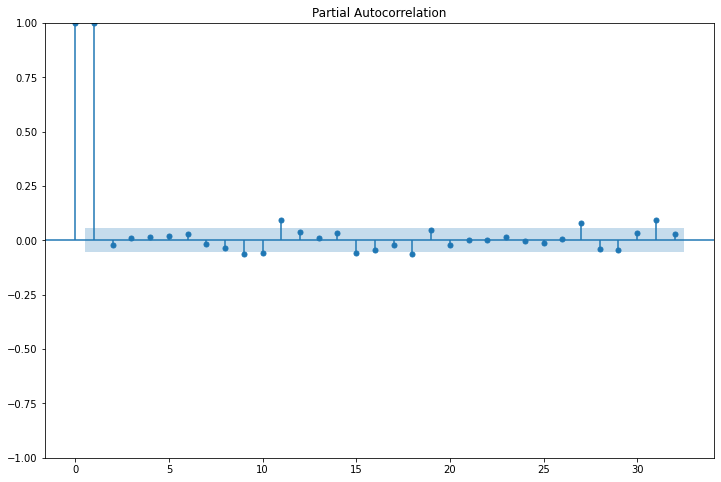

In [10]:
plot_pacf(df)
plt.show()

- Raw_data ACF,PACF<br>
ACF이 서서히 감소하는 비정상 시계열이므로 차분이 필요<br>

In [11]:
train_data = df[:len(df)-30]
test_data = df[len(df)-30:]

In [12]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data['price'].diff() # 차분
diff_train_data = diff_train_data.dropna() # 차분 후 생기는 결측치 제거
print(train_data['price'].head())
print(diff_train_data.head())

date
2018-01-02    51020.0
2018-01-03    51620.0
2018-01-04    51080.0
2018-01-05    52120.0
2018-01-08    52020.0
Name: price, dtype: float64
date
2018-01-03     600.0
2018-01-04    -540.0
2018-01-05    1040.0
2018-01-08    -100.0
2018-01-09   -1620.0
Name: price, dtype: float64


<AxesSubplot:xlabel='date'>

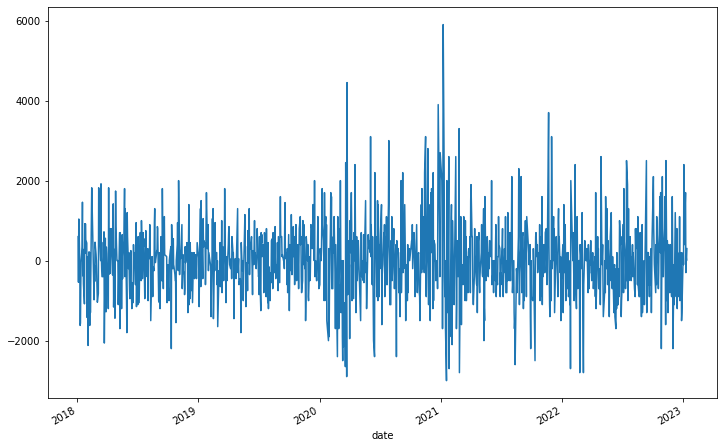

In [13]:
diff_train_data.plot()

In [14]:
adf = adfuller(diff_train_data)
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
# ADF 검정:
# H0: 시계열은 단위근을 포함한다 ( 정상 시계열이 아니다 ) 기각
# pvalue값을 통해 정상 시계열이 됐음을 확인할 수 있다

ADF Statistic: -34.40555639054538
p-value: 0.0


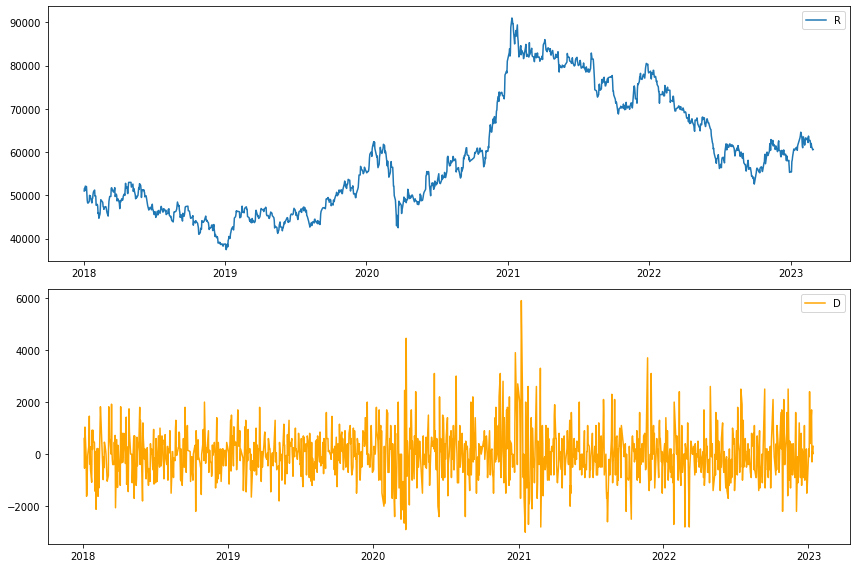

In [15]:
# 차분 전 후 시각화

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(df['price'])
ax1.legend('Raw data (Non-stationary)')

ax2.plot(diff_train_data, color='orange' )
ax2.legend('Differenced data')


plt.tight_layout()
plt.show()

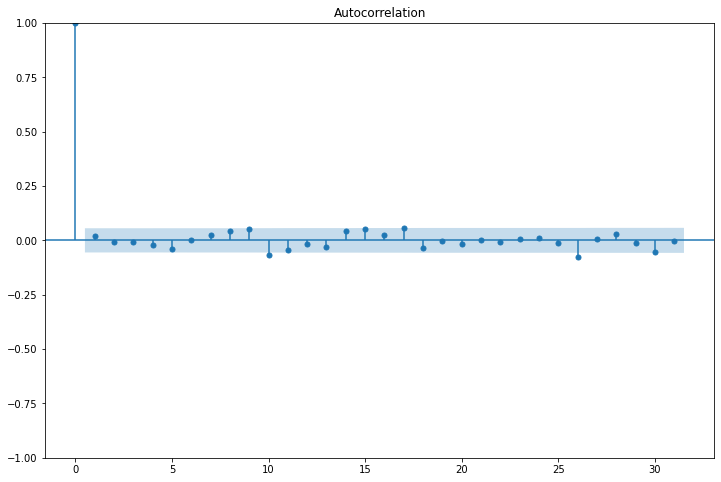

In [16]:
# 차분 후 ACF, PACF plot
plot_acf(diff_train_data)
plt.show()

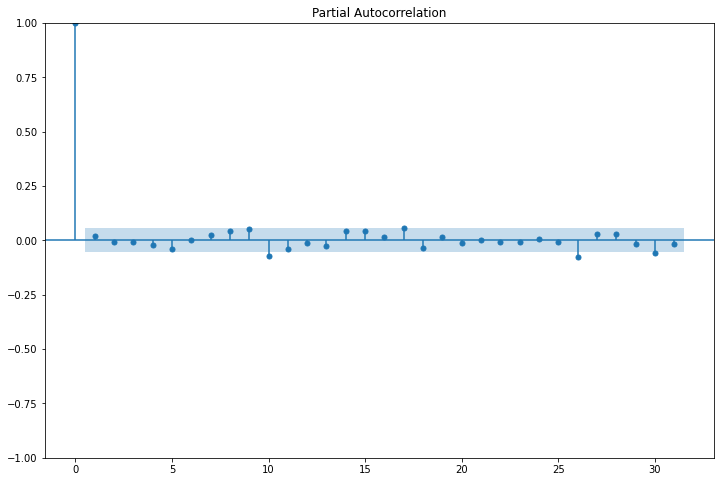

In [17]:
plot_pacf(diff_train_data)
plt.show()

In [18]:
# 최적 파라미터 탐색
import itertools

p = range(0, 3)
d = range(1, 3)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

AIC = []
for i in pdq :
    model = ARIMA(df['price'].values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA pdq : {i} >> AIC : {round(model_fit.aic, 2)}')
    AIC.append(round(model_fit.aic, 2))
    
# AIC가 가장 적어지는 파라미터 선택

ARIMA pdq : (0, 1, 0) >> AIC : 20997.87
ARIMA pdq : (0, 1, 1) >> AIC : 20998.96
ARIMA pdq : (0, 1, 2) >> AIC : 21000.37
ARIMA pdq : (0, 2, 0) >> AIC : 21835.74
ARIMA pdq : (0, 2, 1) >> AIC : 21336.7
ARIMA pdq : (0, 2, 2) >> AIC : 21239.4
ARIMA pdq : (1, 1, 0) >> AIC : 20998.99
ARIMA pdq : (1, 1, 1) >> AIC : 21000.42
ARIMA pdq : (1, 1, 2) >> AIC : 21002.28
ARIMA pdq : (1, 2, 0) >> AIC : 21611.15
ARIMA pdq : (1, 2, 1) >> AIC : 21242.12
ARIMA pdq : (1, 2, 2) >> AIC : 21241.64
ARIMA pdq : (2, 1, 0) >> AIC : 21000.41
ARIMA pdq : (2, 1, 1) >> AIC : 21001.92
ARIMA pdq : (2, 1, 2) >> AIC : 21003.75
ARIMA pdq : (2, 2, 0) >> AIC : 21483.06
ARIMA pdq : (2, 2, 1) >> AIC : 21241.03
ARIMA pdq : (2, 2, 2) >> AIC : 21244.84


In [19]:
# optimal paramter
optim = [(pdq[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print('Found Optimal Parameter :',optim)

Found Optimal Parameter : [((0, 1, 0), 20997.87)]


ARIMA (0,1,0) 모형:1차 차분을 했을 때 백색 잡음 (ϵt∼N(0,σ2))이나<br>
(0,1,0) 모형으로 예측 시 단일값을 예측값으로 가져 (1,2,1)로 변경

In [20]:
model = ARIMA(train_data, order = (1,2,1))
arima_result = model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 1240
Model:                 ARIMA(1, 2, 1)   Log Likelihood              -10367.073
Date:                Tue, 14 Mar 2023   AIC                          20740.145
Time:                        20:45:24   BIC                          20755.509
Sample:                             0   HQIC                         20745.924
                               - 1240                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2504      0.009     28.971      0.000       0.233       0.267
ma.L1         -1.0000      0.027    -36.887      0.000      -1.053      -0.947
sigma2      9.929e+05   2.73e-08   3.64e+13      0.000    9.93e+05    9.93e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.77   Jarque-Bera (JB):              1062.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.12
Prob(H) (two-sided):                  0.13   Kurtosis:                         7.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.46e+28. Standard errors may be unstable.
"""

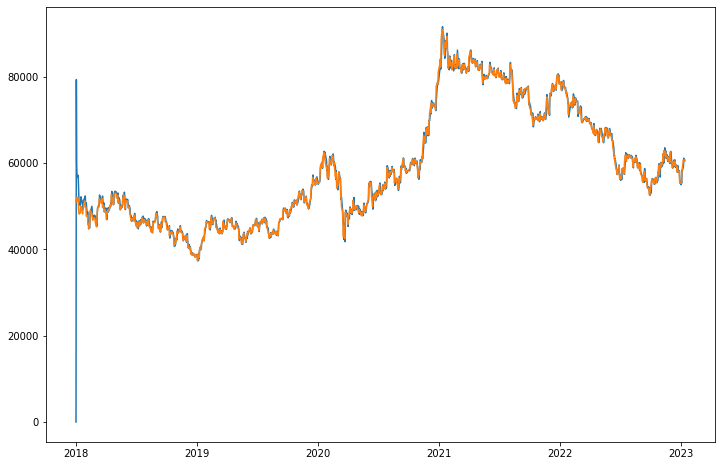

In [21]:
plt.plot(arima_result.predict())
plt.plot(train_data)

In [22]:
forecast_data = arima_result.forecast(steps=30) 
pred_y = forecast_data
pred_y.head()

1240    60898.785841
1241    60947.194569
1242    60982.990600
1243    61015.628845
1244    61047.476489
Name: predicted_mean, dtype: float64

In [23]:
test_y = test_data
test_y.head()

,price
date,
2023-01-16,61100.0
2023-01-17,61000.0
2023-01-18,60400.0
2023-01-19,61500.0
2023-01-20,61800.0


In [24]:
from sklearn.metrics import r2_score, mean_squared_error

print(f'R2_score: {r2_score(test_y, pred_y)}')
print(f'RMSE: {mean_squared_error(test_y, pred_y) ** 0.5}')

# 어디서 오류가 났는지 모르겠습니다 ..(?)

R2_score: -0.7361609755166243
RMSE: 1466.9928365675082
